In [1]:
import os

from google.colab import drive
drive.mount('/content/drive/')

os.chdir('/content/drive/MyDrive/DSCI 552/data')
os.listdir()

Mounted at /content/drive/


['.DS_Store', 'RealWaste']

In [2]:
%pip install tensorflow

In [2]:

import PIL
from PIL import Image
import os
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import random
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# copy files from drive to colab vm, this will accelerate files loading speed.
!cp -r /content/drive/MyDrive/DSCI\ 552/data /content/


In [5]:

os.chdir('/content')
os.listdir() #確認目錄內容

['.config', 'data', 'drive', 'sample_data']

In [6]:
data_path = './data/RealWaste/'
folder_lst = sorted(os.listdir(data_path))
folder_lst.pop(0)

'.DS_Store'

In [7]:
folder_lst

['1-Cardboard',
 '2-Food Organics',
 '3-Glass',
 '4-Metal',
 '5-Miscellaneous Trash',
 '6-Paper',
 '7-Plastic',
 '8-Textile Trash',
 '9-Vegetation']

In [8]:
training_set_path = []
testing_set_path = []
for folder in folder_lst:
    join_path = os.path.join(data_path, folder)
    jpg_lst = os.listdir(join_path)
    training_set_path.append(list(map(lambda x: os.path.join(join_path, x), jpg_lst[:int(len(jpg_lst)*0.8)])))
    testing_set_path.append(list(map(lambda x: os.path.join(join_path, x), jpg_lst[int(len(jpg_lst)*0.8):])))


In [9]:
validation_idx_dict =  {idx+1: random.sample(range(1, len(path_lst)), k=int(len(path_lst)*0.2)) for idx, path_lst in enumerate(training_set_path)}
sub_training_idx_dict = {i: list(set(range(len(training_set_path[i-1]))) - set(validation_idx_dict[i])) for i in range(1, 10)}


In [10]:
validation_set_path = [list(np.array(class_path_lst)[validation_idx_dict[idx+1]]) for idx, class_path_lst in enumerate(training_set_path)]
sub_training_set_path = [list(np.array(class_path_lst)[sub_training_idx_dict[idx+1]]) for idx, class_path_lst in enumerate(training_set_path)]


In [11]:
encoder = OneHotEncoder(sparse_output=False)
convert_labels = encoder.fit_transform([[1], [2], [3], [4], [5], [6], [7], [8], [9],])
oneHot_mapping = {i+1: convert_labels[i] for i in range(9)}
oneHot_mapping

{1: array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 2: array([0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 3: array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 4: array([0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 5: array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 6: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 7: array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 8: array([0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 9: array([0., 0., 0., 0., 0., 0., 0., 0., 1.])}

In [12]:
def data_augmentation(image, crop_size):
    augmentation_layers = [
        layers.Rescaling(scale=1 / 127.5, offset=-1),
        layers.RandomCrop(crop_size[0], crop_size[1]),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.1, value_range=(0, 255)),
        layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    ]

    for layer in augmentation_layers:
        image = layer(image)
    return image

def image_generator(dataset_path: list, oneHot_mapping, augment, crop_size):
    for i, class_paths in enumerate(dataset_path):
        label = oneHot_mapping.get(i + 1)
        for path in class_paths:
            img = Image.open(path).resize((524, 524)).convert("RGB")
            pixels = np.array(img, dtype=np.float32)
            pixels = tf.convert_to_tensor(pixels)

            if augment:
                pixels = data_augmentation(pixels, crop_size)
            else:
                pixels = tf.image.resize(pixels, [crop_size[0], crop_size[1]])
                pixels = pixels / 127.5 - 1

            yield pixels, label

def build_dataset(dataset_path, input_shape, oneHot_mapping, batch_size=64, shuffle=False, augment=False):
    output_signature = (
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=(len(oneHot_mapping),), dtype=tf.float32),
    )

    dataset = tf.data.Dataset.from_generator(
        # This is the most important step, we have to load img one by one or RAM will explode.
        # So, we use from_generator() to read img one by one. The key point is using lambda on image_generator()
        # The lambda: image_generator(...) is used because tf.data.Dataset.from_generator() expects a callable function that returns a generator when called.
        # lambda: image_generator(...) is a function that returns a new generator each time it's called. This allows from_generator to iterate over the data in batches.
        # image_generator(...) directly runs and returns an already generated sequence of data, which is not what from_generator expects.
        # In short, lambda is used to ensure the generator is produced only when needed, rather than executing it upfront.
        lambda: image_generator(dataset_path, oneHot_mapping, augment=augment, crop_size=input_shape),
        output_signature=output_signature
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

input_shape = (224, 224, 3)
sub_training_set = build_dataset(training_set_path, input_shape, oneHot_mapping, shuffle=True, augment=True)
original_sub_training_set = build_dataset(validation_set_path, input_shape, oneHot_mapping)
validation_set = build_dataset(validation_set_path, input_shape, oneHot_mapping)
testing_set = build_dataset(testing_set_path, input_shape,oneHot_mapping)


In [13]:
def network_training(base_model, model_name, inputs, epoch, training_dataset, validation_dataset, model_save_path):

  if os.path.exists(f'{model_save_path}{model_name}_best_model.keras'):
      print(f"Loading existing model from {model_save_path}")

      model = keras.models.load_model(f"{model_save_path}best_model.keras")
  else:
      x = base_model(inputs, training=False)
      x = keras.layers.GlobalAveragePooling2D()(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Dropout(0.2)(x)
      # x = keras.layers.Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(x)
      x = keras.layers.Activation('relu')(x)
      x = keras.layers.Dense(9, kernel_regularizer=l2(0.00001),use_bias=True)(x)
      x = keras.layers.BatchNormalization()(x)
      outputs = keras.layers.Activation('softmax')(x)

      model = keras.Model(inputs, outputs, name=model_name)
      model.summary(show_trainable=True)
      model.compile(
          optimizer=keras.optimizers.Adam(),
          loss=keras.losses.CategoricalCrossentropy(from_logits=False),
          metrics=[
              keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
              Precision(name="precision"),
              Recall(name="recall"),
              AUC(name="auc")
          ]
      )

  os.chdir(model_save_path)
  # Set up ModelCheckpoint callback
  checkpoint_callback = ModelCheckpoint(
      f'./{model_name}_best_model.keras',  # File name where the model will be saved
      monitor='val_loss',  # Monitor validation loss
      verbose=1,  # Display messages when saving the model
      save_best_only=True,  # Save only the best model
      mode='min',  # Minimize the loss
      save_weights_only=False  # Save the full model, not just weights
  )

  early_stop_callback = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True,
      verbose=1,
      mode='min'
  )

  history = model.fit(training_dataset, epochs=epoch, validation_data=validation_dataset, callbacks=[early_stop_callback])

  # train_proba, train_pred, train_true, train_true_onehot = output(model, training_dataset)
  # val_proba, val_pred, val_true, val_true_onehot = output(model, validation_dataset)

  return model, history
  # , (train_proba, train_pred, train_true, train_true_onehot), (val_proba, val_pred, val_true, val_true_onehot)

In [21]:
def output(_model, dataset):
  with tf.device('/GPU:0'):
    y_proba = _model.predict(dataset)
    y_pred = np.array([int(np.argmax(pred)) for pred in y_proba])
    y_true, y_true_onehot = [], []
    for _, labels in dataset:
        for label in labels:
          y_true.append(int(np.argmax(label.numpy())+1))
          y_true_onehot.append(label.numpy())
    y_proba, y_pred, y_true, y_true_onehot = np.array(y_proba), np.array(y_pred), np.array(y_true), np.array(y_true_onehot)
    return y_proba, y_pred, y_true, y_true_onehot

def metrics(y_true, y_pred):
  # Precision, Recall, F1
  precision = precision_score(y_true, y_pred, average='macro', zero_division = 0)
  recall = recall_score(y_true, y_pred, average='macro', zero_division = 0)
  f1 = f1_score(y_true, y_pred, average='macro')
  return precision, recall, f1

def plot_training_history(model_name, history):
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    plt.figure(figsize=(8, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_result(model_name, history, test_info, train_info, val_info):
  plot_training_history(model_name, history)

  print(f"{model_name} testing:")
  test_proba, test_pred, test_true, test_true_onehot = test_info[0], test_info[1], test_info[2], test_info[3]
  test_precision, test_recall, test_f1 = metrics(test_true, test_pred)
  test_auc = roc_auc_score(test_true_onehot, test_proba, multi_class='ovr', average='macro')
  print(f"test_precision: {test_precision}, test_recall: {test_recall}, test_f1: {test_f1}, test_AUC: {test_auc}")

  print(f"{model_name} validation:")
  val_proba, val_pred, val_true, val_true_onehot = val_info[0], val_info[1], val_info[2], val_info[3]
  val_precision, val_recall, val_f1 = metrics(val_true, val_pred)
  print(f"val_precision: {val_precision}, val_recall: {val_recall}, val_f1: {val_f1}, val_AUC: {history.history['val_auc']}")

  print(f"{model_name} training:")
  train_proba, train_pred, train_true, train_true_onehot = train_info[0], train_info[1], train_info[2], train_info[3]
  train_precision, train_recall, train_f1 = metrics(train_true, train_pred)
  print(f"train_precision: {train_precision}, train_recall: {train_recall}, train_f1: {train_f1}, train_AUC: {history.history['auc']}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_8 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50 (Functional)       │ (None, 7, 7, 2048)    │ 23,587,712 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 2048)          │      8,192 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_2 (Activation)   │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 9)             │     18,441 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_3       │ (None, 9)             │         36 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_3 (Activation)   │ (None, 9)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,614,381 (90.08 MB)

 Trainable params: 22,555 (88.11 KB)

 Non-trainable params: 23,591,826 (90.00 MB)

Epoch 1/50
     60/Unknown 250s 4s/step - auc: 0.4831 - categorical_accuracy: 0.0950 - loss: 2.3586 - precision: 0.1100 - recall: 0.0033

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - auc: 0.4830 - categorical_accuracy: 0.0946 - loss: 2.3573 - precision: 0.1100 - recall: 0.0033 - val_auc: 0.5050 - val_categorical_accuracy: 0.0860 - val_loss: 2.4065 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - auc: 0.5584 - categorical_accuracy: 0.1321 - loss: 2.1831 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5123 - val_categorical_accuracy: 0.0939 - val_loss: 2.2376 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - auc: 0.5633 - categorical_accuracy: 0.1245 - loss: 2.1786 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5348 - val_categorical_accuracy: 0.1045 - val_loss: 2.1905 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - auc: 0.5663 - categorical_accuracy: 0.1256 - loss: 2.1764 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5799 - 

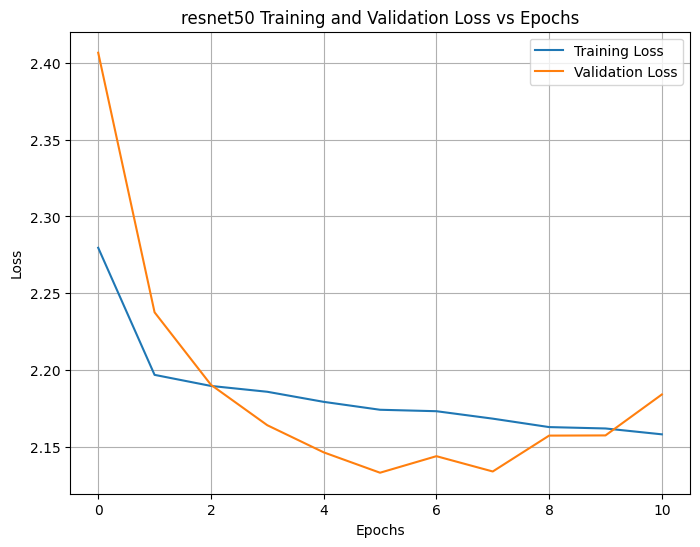

resnet50 testing:
test_precision: 0.07153263142174433, test_recall: 0.061709397656978304, test_f1: 0.04033797328316585, test_AUC: 0.6724608180491133
resnet50 validation:
val_precision: 0.04853614423736376, val_recall: 0.060445488543969604, val_f1: 0.03800603384201967, val_AUC: [0.5049610137939453, 0.5122917890548706, 0.5348486304283142, 0.5799420475959778, 0.6226407885551453, 0.6368957161903381, 0.6339508295059204, 0.6437386870384216, 0.6362740397453308, 0.6469654440879822, 0.6361134648323059]
resnet50 training:
train_precision: 0.04853614423736376, train_recall: 0.060445488543969604, train_f1: 0.03800603384201967, train_AUC: [0.4769437909126282, 0.5277076959609985, 0.5433562994003296, 0.5517047047615051, 0.5648016929626465, 0.5748807787895203, 0.5749427080154419, 0.5830204486846924, 0.5882182121276855, 0.5904162526130676, 0.5919660925865173]


In [22]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classifier_activation="softmax",
    name="resnet50",
)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
with tf.device('/GPU:0'):
  model, history = network_training(base_model, "resnet50", inputs, 50, sub_training_set, validation_set, "/content/drive/MyDrive/DSCI 552/")
  test_proba, test_pred, test_true, test_true_onehot = output(model, testing_set)
  train_proba, train_pred, train_true, train_true_onehot = output(model, original_sub_training_set)
  val_proba, val_pred, val_true, val_true_onehot = output(model, validation_set)
  print_result("resnet50", history,
              (test_proba, test_pred, test_true, test_true_onehot),
              (train_proba, train_pred, train_true, train_true_onehot),
              (val_proba, val_pred, val_true, val_true_onehot))

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet101 (Functional)      │ (None, 7, 7, 2048)    │ 42,658,176 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_4       │ (None, 2048)          │      8,192 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_4 (Activation)   │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 9)             │     18,441 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_5       │ (None, 9)             │         36 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_5 (Activation)   │ (None, 9)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 42,684,845 (162.83 MB)

 Trainable params: 22,555 (88.11 KB)

 Non-trainable params: 42,662,290 (162.74 MB)

Epoch 1/50
     60/Unknown 252s 4s/step - auc: 0.5103 - categorical_accuracy: 0.1063 - loss: 2.3308 - precision: 0.0633 - recall: 0.0014

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - auc: 0.5099 - categorical_accuracy: 0.1059 - loss: 2.3297 - precision: 0.0635 - recall: 0.0014 - val_auc: 0.5055 - val_categorical_accuracy: 0.1138 - val_loss: 2.2242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - auc: 0.5603 - categorical_accuracy: 0.1595 - loss: 2.1794 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5619 - val_categorical_accuracy: 0.1402 - val_loss: 2.1729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - auc: 0.5630 - categorical_accuracy: 0.1613 - loss: 2.1750 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6207 - val_categorical_accuracy: 0.1878 - val_loss: 2.1486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - auc: 0.5661 - categorical_accuracy: 0.1389 - loss: 2.1711 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.6605 - 

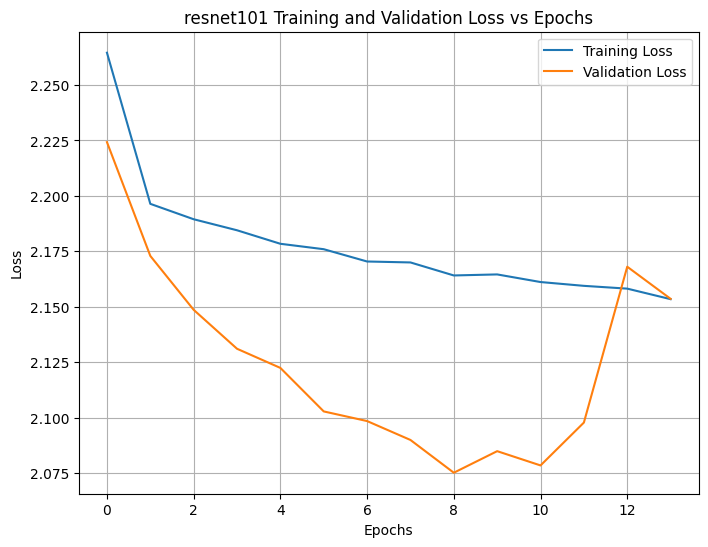

resnet101 testing:
test_precision: 0.10227360287246809, test_recall: 0.07199987663092502, test_f1: 0.05225356239136499, test_AUC: 0.6673878346667088
resnet101 validation:
val_precision: 0.057821802752470654, val_recall: 0.06218774110125258, val_f1: 0.04471074006627877, val_AUC: [0.5054630637168884, 0.5618610382080078, 0.62071293592453, 0.6605052947998047, 0.6594549417495728, 0.6723428964614868, 0.670346200466156, 0.677418053150177, 0.6796280145645142, 0.6710091233253479, 0.6689691543579102, 0.6539549231529236, 0.6225331425666809, 0.6247802972793579]
resnet101 training:
train_precision: 0.057821802752470654, train_recall: 0.06218774110125258, train_f1: 0.04471074006627877, train_AUC: [0.49007678031921387, 0.528873085975647, 0.5438232421875, 0.5516964197158813, 0.5628105998039246, 0.5700163841247559, 0.5752769708633423, 0.5769544839859009, 0.5890812873840332, 0.5881186723709106, 0.5899004936218262, 0.5948820114135742, 0.594904899597168, 0.6015221476554871]


In [23]:
base_model = keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classifier_activation="softmax",
    name="resnet101",
)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
with tf.device('/GPU:0'):
  model, history = network_training(base_model, "resnet101", inputs, 50, sub_training_set, validation_set, "/content/drive/MyDrive/DSCI 552/")
  test_proba, test_pred, test_true, test_true_onehot = output(model, testing_set)
  train_proba, train_pred, train_true, train_true_onehot = output(model, original_sub_training_set)
  val_proba, val_pred, val_true, val_true_onehot = output(model, validation_set)
  print_result("resnet101", history,
              (test_proba, test_pred, test_true, test_true_onehot),
              (train_proba, train_pred, train_true, train_true_onehot),
              (val_proba, val_pred, val_true, val_true_onehot))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_12 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ VGG16 (Functional)          │ (None, 7, 7, 512)     │ 14,714,688 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_3  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_6       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_6 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 9)             │      4,617 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_7       │ (None, 9)             │         36 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_7 (Activation)   │ (None, 9)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,721,389 (56.16 MB)

 Trainable params: 5,659 (22.11 KB)

 Non-trainable params: 14,715,730 (56.14 MB)

Epoch 1/50
     60/Unknown 261s 4s/step - auc: 0.5160 - categorical_accuracy: 0.1355 - loss: 2.4762 - precision: 0.1748 - recall: 0.0140

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - auc: 0.5160 - categorical_accuracy: 0.1352 - loss: 2.4753 - precision: 0.1743 - recall: 0.0139 - val_auc: 0.6316 - val_categorical_accuracy: 0.2011 - val_loss: 2.1341 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - auc: 0.5705 - categorical_accuracy: 0.1637 - loss: 2.2047 - precision: 0.3181 - recall: 0.0017 - val_auc: 0.6965 - val_categorical_accuracy: 0.2910 - val_loss: 2.0777 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - auc: 0.5746 - categorical_accuracy: 0.1540 - loss: 2.1800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.7390 - val_categorical_accuracy: 0.3148 - val_loss: 2.0504 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - auc: 0.5916 - categorical_accuracy: 0.1726 - loss: 2.1606 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.7696 - val_cate

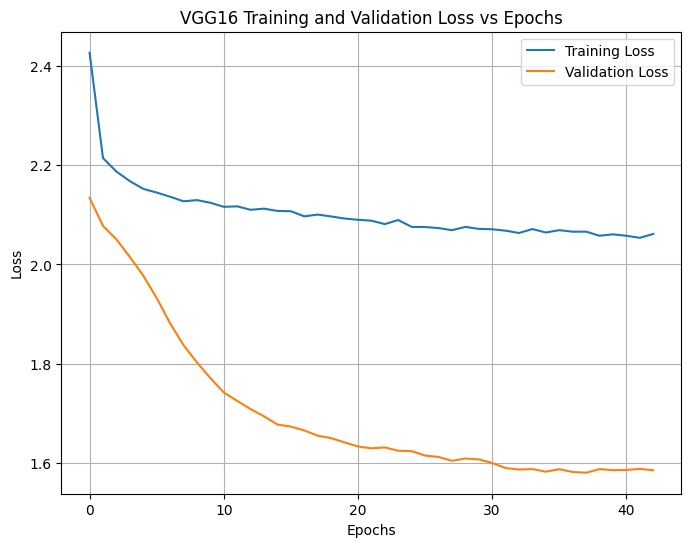

VGG16 testing:
test_precision: 0.03970848120738339, test_recall: 0.0463740407109129, test_f1: 0.038093367002375866, test_AUC: 0.8703413341719882
VGG16 validation:
val_precision: 0.028773650855975313, val_recall: 0.03587527554460305, val_f1: 0.028465828253181374, val_AUC: [0.6315861940383911, 0.6964871883392334, 0.7390071749687195, 0.7696333527565002, 0.7926457524299622, 0.8093565106391907, 0.8222331404685974, 0.8304332494735718, 0.8326964974403381, 0.83670574426651, 0.8391825556755066, 0.8390640616416931, 0.8435117602348328, 0.848807692527771, 0.8529170751571655, 0.8529918789863586, 0.8525606393814087, 0.8542342185974121, 0.8571452498435974, 0.8604381084442139, 0.8621968030929565, 0.8609139323234558, 0.8609676957130432, 0.8604204058647156, 0.8623337149620056, 0.8641243577003479, 0.864924967288971, 0.8657971024513245, 0.8637877106666565, 0.8663555383682251, 0.8663578033447266, 0.8684757351875305, 0.8706502318382263, 0.8705540299415588, 0.870660126209259, 0.8713878989219666, 0.8727735877

In [24]:
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classifier_activation="softmax",
    name="VGG16",
)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
with tf.device('/GPU:0'):
  model, history = network_training(base_model, "VGG16", inputs, 50, sub_training_set, validation_set, "/content/drive/MyDrive/DSCI 552/")
  test_proba, test_pred, test_true, test_true_onehot = output(model, testing_set)
  train_proba, train_pred, train_true, train_true_onehot = output(model, original_sub_training_set)
  val_proba, val_pred, val_true, val_true_onehot = output(model, validation_set)
  print_result("VGG16", history,
              (test_proba, test_pred, test_true, test_true_onehot),
              (train_proba, train_pred, train_true, train_true_onehot),
              (val_proba, val_pred, val_true, val_true_onehot))

In [ ]:
os.chdir('/content/drive/MyDrive/DSCI 552/')


base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    # classifier_activation="softmax",
    name="EfficientNetB0",
)
base_model.load_weights(r"./efficientnetb0_notop.h5")
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
with tf.device('/GPU:0'):
  model, history = network_training(base_model, "EfficientNetB0", inputs, 50, sub_training_set, validation_set, "/content/drive/MyDrive/DSCI 552/")
  test_proba, test_pred, test_true, test_true_onehot = output(model, testing_set)
  train_proba, train_pred, train_true, train_true_onehot = output(model, original_sub_training_set)
  val_proba, val_pred, val_true, val_true_onehot = output(model, validation_set)
  print_result("EfficientNetB0", history,
              (test_proba, test_pred, test_true, test_true_onehot),
              (train_proba, train_pred, train_true, train_true_onehot),
              (val_proba, val_pred, val_true, val_true_onehot))

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_14 (InputLayer) │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ EfficientNetB0 (Functional) │ (None, 7, 7, 1280)    │  4,049,571 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_4  │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_8       │ (None, 1280)          │      5,120 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_8 (Activation)   │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 9)             │     11,529 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_9       │ (None, 9)             │         36 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_9 (Activation)   │ (None, 9)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 4,066,256 (15.51 MB)

 Trainable params: 14,107 (55.11 KB)

 Non-trainable params: 4,052,149 (15.46 MB)

Epoch 1/50
     60/Unknown 243s 4s/step - auc: 0.5147 - categorical_accuracy: 0.1062 - loss: 2.3369 - precision: 0.0182 - recall: 5.4354e-04

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


60/60 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - auc: 0.5142 - categorical_accuracy: 0.1057 - loss: 2.3356 - precision: 0.0182 - recall: 5.3895e-04 - val_auc: 0.5414 - val_categorical_accuracy: 0.1667 - val_loss: 2.1926 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - auc: 0.5164 - categorical_accuracy: 0.1140 - loss: 2.1957 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5579 - val_categorical_accuracy: 0.1032 - val_loss: 2.1902 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - auc: 0.5312 - categorical_accuracy: 0.1068 - loss: 2.1940 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5778 - val_categorical_accuracy: 0.1958 - val_loss: 2.1879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - auc: 0.5438 - categorical_accuracy: 0.1053 - loss: 2.1917 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.597